# Playground for exploration and learning GPyTorch essentials

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

### Set up training and test data

In [2]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

test_x = torch.linspace(0, 1, 20)
# test_y = torch.sin(test_x * (2 * math.pi)) + torch.randn(test_x.size()) * 0.5

### Set up the GP model

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean=mean_x, covariance_matrix=covar_x)

# initialize the likelihood and model for simple regression
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
# Check out the model parameters
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

for param in model.parameters():
    print(f'Parameter value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
Parameter value = 0.0
Parameter value = 0.0
Parameter value = 0.0
Parameter value = 0.0


### Train the GP model

In [5]:
n_iter = 30

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(n_iter):

    # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = model(train_x)

    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, n_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/30 - Loss: 0.933   lengthscale: 0.693   noise: 0.693
Iter 2/30 - Loss: 0.901   lengthscale: 0.644   noise: 0.644
Iter 3/30 - Loss: 0.867   lengthscale: 0.598   noise: 0.598
Iter 4/30 - Loss: 0.830   lengthscale: 0.555   noise: 0.554
Iter 5/30 - Loss: 0.788   lengthscale: 0.514   noise: 0.513
Iter 6/30 - Loss: 0.741   lengthscale: 0.475   noise: 0.474
Iter 7/30 - Loss: 0.692   lengthscale: 0.438   noise: 0.437
Iter 8/30 - Loss: 0.642   lengthscale: 0.404   noise: 0.402
Iter 9/30 - Loss: 0.594   lengthscale: 0.371   noise: 0.370
Iter 10/30 - Loss: 0.550   lengthscale: 0.341   noise: 0.339
Iter 11/30 - Loss: 0.510   lengthscale: 0.315   noise: 0.311
Iter 12/30 - Loss: 0.474   lengthscale: 0.292   noise: 0.284
Iter 13/30 - Loss: 0.440   lengthscale: 0.272   noise: 0.260
Iter 14/30 - Loss: 0.406   lengthscale: 0.257   noise: 0.237
Iter 15/30 - Loss: 0.374   lengthscale: 0.244   noise: 0.216
Iter 16/30 - Loss: 0.342   lengthscale: 0.234   noise: 0.197
Iter 17/30 - Loss: 0.310   length

### Make predictions on test data

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)
    y_preds = likelihood(f_preds)
    
print(f_preds)
print(y_preds)

MultivariateNormal(loc: torch.Size([20]))
MultivariateNormal(loc: torch.Size([20]))


### Plot the model fit

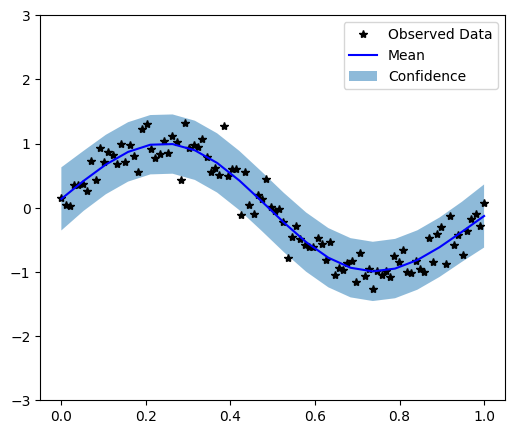

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), y_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])